In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reliance-nse-stock-data/RILO - Copy.csv


# Stock Price Prediction for RELIND stock
The first thing I did after I recieved my first salary? I invested a 10K directly to the RELIND stock and well...... I faced loss. 
So well, in this notebook, I would want to perhaps try and predict the future?

In [24]:
!pip install pmdarima

In [25]:
import numpy as np
import pandas as pd

import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
import pandas_datareader as web
import datetime as dt
plt.style.use('ggplot') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from plotly import tools
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [26]:
df=pd.read_csv('../input/reliance-nse-stock-data/RILO - Copy.csv')
df.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,RELIANCE,EQ,1-Jan-16,1014.60,1009.80,1018.9,1008.20,1013.6,1015.35,1015.52,1238135,1.257353e+09,30701,529539,42.77
1,RELIANCE,EQ,4-Jan-16,1015.35,1005.00,1013.8,986.70,993.2,995.30,998.91,6896571,6.889070e+09,66235,4974602,72.13
2,RELIANCE,EQ,5-Jan-16,995.30,1000.30,1010.0,997.00,1005.0,1005.15,1003.41,3416459,3.428125e+09,59935,1987804,58.18
3,RELIANCE,EQ,6-Jan-16,1005.15,1007.60,1038.4,1000.40,1029.1,1032.20,1028.15,6116855,6.289073e+09,160947,2912662,47.62
4,RELIANCE,EQ,7-Jan-16,1032.20,1021.05,1028.0,1008.05,1018.9,1013.25,1016.73,4512219,4.587700e+09,105075,2474491,54.84


## PART 1 - EDA

In [27]:
df = df.dropna()

In [28]:
df['Date'] = pd.to_datetime(df['Date'])

In [29]:
#Check for Null Values
df.isnull().sum().sum()

0

In [30]:
# Plot the Closing Point Figure
fig = go.Figure()

fig = make_subplots(rows=2, cols=1,subplot_titles=("RELIND NSE Candlestick Chart","RELIND NSE Volume"))
fig.append_trace(go.Scatter(x=df['Date'], y=df['Close Price'],
                    mode='lines',
                    name='lines'),row=1,col=1)

fig.append_trace(go.Scatter(x=df['Date'], y=df['Total Traded Quantity'],
                    mode='lines',
                    name='lines'),row=2,col=1)

fig.update_layout(title="RELIND NSE Exploratory Data Analysis",
    xaxis_title="Price",
        yaxis_title="Time Period",height=800)


fig.show()

In [31]:
# Plot the Candlestick Chart
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open Price'],
                high=df['High Price'],
                low=df['Low Price'],
                close=df['Close Price'])])
fig.update_layout(title="RELIND NSE Candlestick Graph",
    xaxis_title="Price",
        yaxis_title="Time Period")

fig.show()

In [32]:
#Create Rolling Means for The Stock Data
tenDay = df['Close Price'].rolling(10).mean()
twentyDay = df['Close Price'].rolling(20).mean()
fiftyDay = df['Close Price'].rolling(50).mean()
EMA20Day = df['Close Price'].ewm(span=20,adjust=False).mean()
EMA200Day = df['Close Price'].ewm(span=200,adjust=False).mean()

df['tenDay'] = tenDay
df['twentyDay'] = twentyDay
df['fiftyDay'] = fiftyDay
df['EMA20Day'] = EMA20Day
df['EMA200Day'] = EMA200Day


fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close Price'], name='Actual Close Price',
                         line=dict(color='#489ac7', width=1.5)))
fig.add_trace(go.Scatter(x=df['Date'], y=df['tenDay'], name='Ten Day Rolling Mean ',
                         line=dict(color='#f79763', width=1)))
fig.add_trace(go.Scatter(x=df['Date'], y=df['twentyDay'], name='Twenty Day Rolling Mean ',
                         line=dict(color='#b563f7', width=1)))
fig.add_trace(go.Scatter(x=df['Date'], y=df['fiftyDay'], name='Fifty Day Rolling Mean ',
                         line=dict(color='#f76386', width=1)))
fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA20Day'], name='EMA Twenty Days ',
                         line=dict(color='#3bffa0', width=2)))
fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA200Day'], name='EMA TwoHundred Days ',
                         line=dict(color='#36074a', width=1.5)))

fig.update_layout(title="RELIND NSE Moving Averages",
    xaxis_title="Price",
        yaxis_title="Time Period")

In [33]:
#draw a quick correlation plot (drop time as a feature)
#also realise that it does not provide much information, now that we already know it is a time series
correlation_df = df.copy()
correlation_df = correlation_df.drop(columns =['Symbol','Series','Date'])
corr = correlation_df.corr()


fig = go.Figure(data=[go.Heatmap(z=corr.values,
                  x=corr.index.values,
                  y=corr.columns.values)])
fig.update_layout(title="Correlation Heatmap",height=600,width=800)
fig.show()

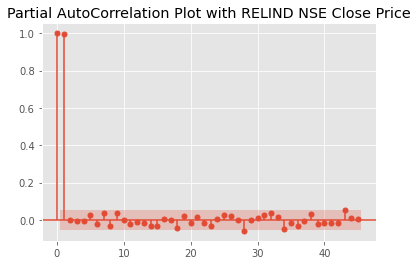

<Figure size 432x288 with 0 Axes>

In [34]:
# Partial Auto Correlation Plot
plot_pacf(df["Close Price"],lags=45,title="Partial AutoCorrelation Plot with RELIND NSE Close Price")
plt.figure()
plt.show()

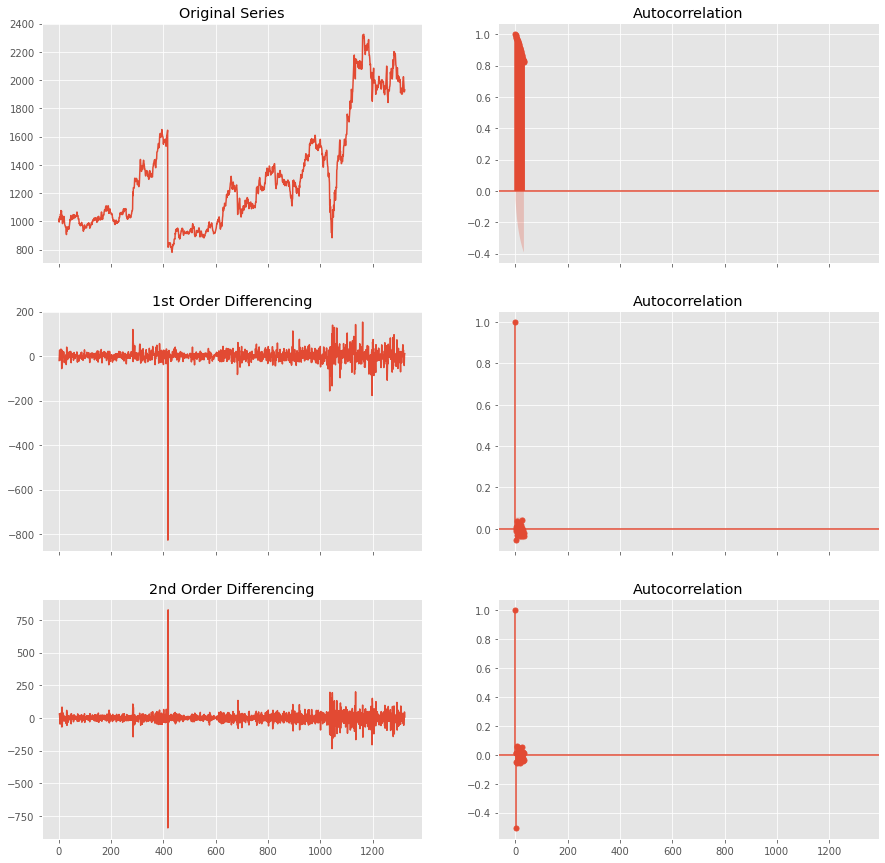

In [35]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df["Close Price"]); axes[0, 0].set_title('Original Series')
plot_acf(df["Close Price"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df["Close Price"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df["Close Price"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df["Close Price"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df["Close Price"].diff().diff().dropna(), ax=axes[2, 1])
fig.set_size_inches(15, 15)
plt.show()

## PART 2 - Time Series Analysis

In [36]:
# Augmented Dickey Fuller Test, in order to check if the time series is stationary.
# Null Hypothesis means that the data is not stationary.
# Alternate Hypothesis means that the data is stationary 
def stationaryTest(dataframe):
    adft = adfuller(dataframe,autolag='AIC')
    labelsADF= ['Test Statistics','p-value','No. of lags used','Number of observations used']
    for values,labels in zip(adft,labelsADF):
        print (labels + " : " + str(values))
    if (adft[1]<= 0.05):
        print("Reject the Null Hypothesis. Data is Stationary")
    else:
        print("Accept the Null Hypothesis. The TS is not stationary")
        
stationaryTest(df['Close Price'])

Test Statistics : -1.3517501576682647
p-value : 0.6051768942409834
No. of lags used : 0
Number of observations used : 1323
Accept the Null Hypothesis. The TS is not stationary


<Figure size 432x288 with 0 Axes>

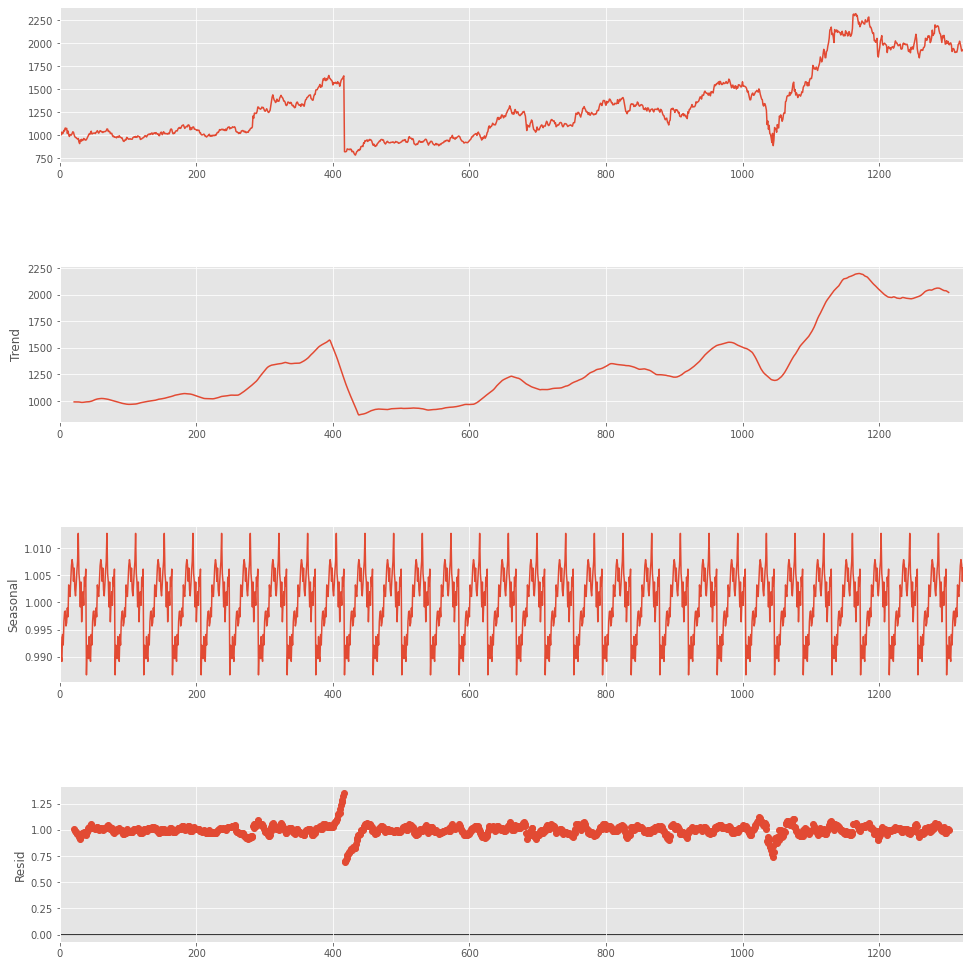

In [37]:
# Decompose Seasonality from the Datas
result = seasonal_decompose(df[['Close Price']], model='multiplicative', freq = 42)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 15)

In [38]:
# Check if the Residual Value is Stationary, if yes then the period
df['residualAfterDecomposition']= result.resid
stationaryTest(df['residualAfterDecomposition'].dropna())

Test Statistics : -10.363811568073144
p-value : 2.3586993726652758e-18
No. of lags used : 15
Number of observations used : 1266
Reject the Null Hypothesis. Data is Stationary


In [39]:
df['residualAfterDecomposition']=df['residualAfterDecomposition'].dropna()
df['residualAfterDecomposition'] = df['residualAfterDecomposition'].reset_index()
df['residualAfterDecomposition'] = df['residualAfterDecomposition'].drop(columns='index')

## Predict the Future Values using Auto ARIMA

In [40]:
df['Close Price']

0       1015.35
1        995.30
2       1005.15
3       1032.20
4       1013.25
         ...   
1319    1994.50
1320    1959.05
1321    1916.60
1322    1920.10
1323    1931.00
Name: Close Price, Length: 1324, dtype: float64

In [41]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(df['Close Price'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=100, max_q=100, # maximum p and q
                      m=45,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[45] intercept   : AIC=13135.308, Time=4.91 sec
 ARIMA(0,1,0)(0,0,0)[45] intercept   : AIC=13129.426, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[45] intercept   : AIC=13133.306, Time=2.05 sec
 ARIMA(0,1,1)(0,0,1)[45] intercept   : AIC=13133.311, Time=2.37 sec
 ARIMA(0,1,0)(0,0,0)[45]             : AIC=13127.957, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[45] intercept   : AIC=13131.309, Time=2.95 sec
 ARIMA(0,1,0)(0,0,1)[45] intercept   : AIC=13131.311, Time=3.58 sec
 ARIMA(0,1,0)(1,0,1)[45] intercept   : AIC=13133.284, Time=5.66 sec
 ARIMA(1,1,0)(0,0,0)[45] intercept   : AIC=13131.421, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[45] intercept   : AIC=13131.424, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[45] intercept   : AIC=13133.423, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[45]          
Total fit time: 21.915 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observa

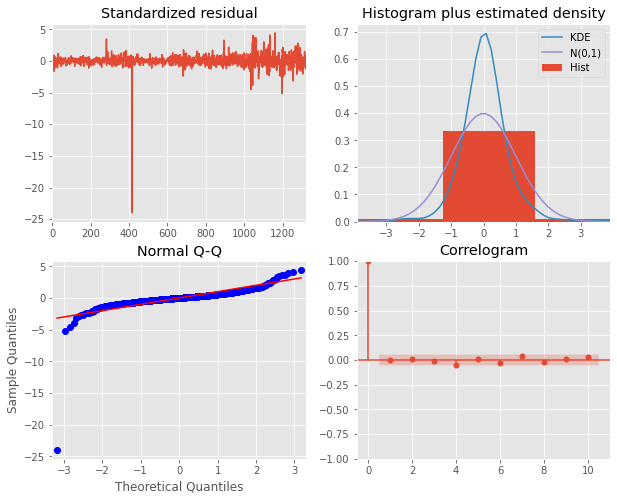

In [42]:
model.plot_diagnostics(figsize=(10,8))
fig.set_size_inches(15, 15)
plt.show()

Text(0.5, 1.0, 'Final Forecast of Usage')

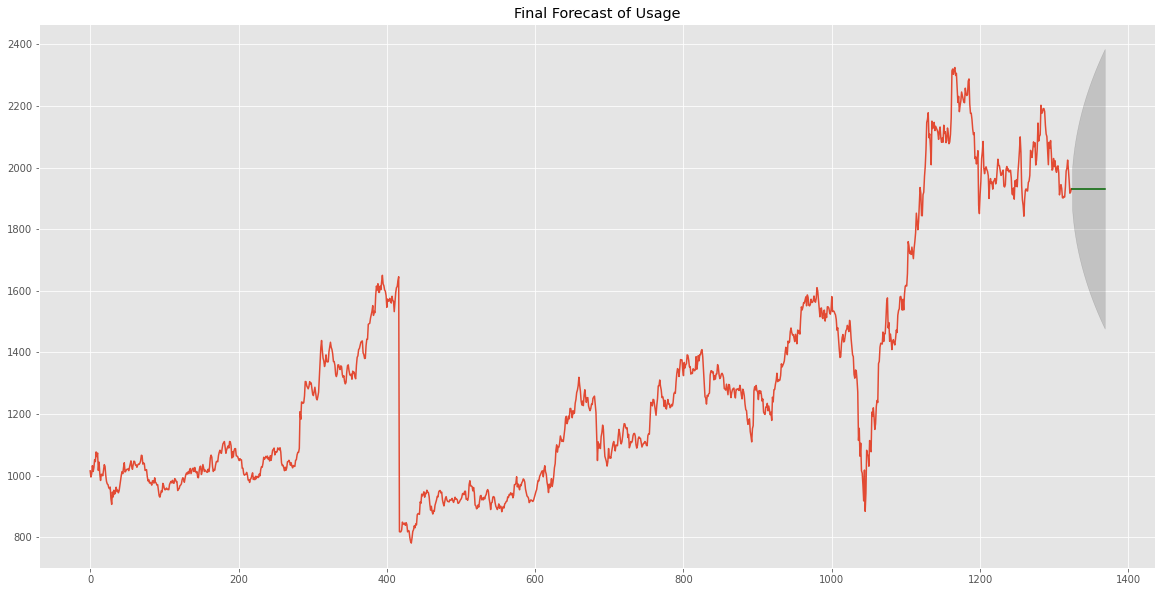

In [43]:
# Forecast
n_periods = 45
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close Price']), len(df['Close Price'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(df['Close Price'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")

## Stock Price Prediction using LSTM

Solution Inspired from -> https://www.kaggle.com/adrianmcmahon/reliance-future-prediction-of-close-price-lstm

In [59]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout
import math
from sklearn.metrics import mean_squared_error

In [60]:
data = df.filter(['Close Price'])
# Select the Close Price as the feature
dataset = data.values
# Get the Values
training_data_len = math.ceil(len(dataset) * .9)
# Cut 20% into the validation dataset

In [61]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
# Scale the Dataset

In [62]:
def splitting(period,data):
    scaled_data = data
    period = period
    
    ## Initialize variables #########
    train_data = scaled_data[0:training_data_len, :]
    test_data = scaled_data[training_data_len - period: , :]
    x_train = []
    y_train = []
    x_test = []
    y_test = dataset[training_data_len:, :]
    
    # Take old "PERIOD" day close price as the feature, and keep y as the label
    # Apparently, using a "period" prior data, being the x, the y will be the future data.
    for i in range(period, len(train_data)):
        x_train.append(train_data[i-period:i, 0])
        y_train.append(train_data[i, 0])
    for i in range (period, len(test_data)):
        x_test.append(test_data[i - period:i, 0])   

 
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test = np.array(x_test)
    # We need to keep a shape similar to (N_samples, Rolling Window Size , No of Features)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))       
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = splitting(100,scaled_data)

In [63]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = False))
#model.add(Dropout(0.2))
#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

1092/1092 [==============================] - 49s 42ms/step - loss: 0.0056


In [64]:
'''test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range (60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rsme = np.sqrt(np.mean(predictions - y_test) ** 2)
rsme'''

'test_data = scaled_data[training_data_len - 60: , :]\nx_test = []\ny_test = dataset[training_data_len:, :]\n\nfor i in range (60, len(test_data)):\n    x_test.append(test_data[i - 60:i, 0])\n\nx_test = np.array(x_test)\nx_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))\n\npredictions = model.predict(x_test)\npredictions = scaler.inverse_transform(predictions)\n\nrsme = np.sqrt(np.mean(predictions - y_test) ** 2)\nrsme'

In [65]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)   

In [67]:
print("Click and drag on the plot to zoom in, you can reset using the top right option")

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

fig = go.Figure()
fig.add_trace(go.Scatter(x = valid.index, y = valid['Close Price'],
                    mode='lines',
                    name='Val',
                    marker_color = '#FF7F0E'))
fig.add_trace(go.Scatter(x = valid.index, y = valid.Predictions,
                    mode='lines',
                    name='Predictions',
                    marker_color = '#2CA02C'))

fig.update_layout(
    title='Model', titlefont_size = 28, hovermode = 'x',
    xaxis = dict(
        title='Date',
        titlefont_size=16,
        tickfont_size=14),
    
    height = 800,
    
    yaxis=dict(
        title='Close price in INR (₹)',
        titlefont_size=16,
        tickfont_size=14),
    legend=dict(
        y=0,
        x=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'))

fig.show()

Click and drag on the plot to zoom in, you can reset using the top right option
